In [51]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pysyncon import Dataprep, Synth, AugSynth

In [52]:
# All states:
states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]
# States belonging to RGGI. Exclude VA here; it was only in RGGI for a short time
# Connecticut, Delaware, Maine, Maryland, Massachusetts, New Hampshire, New Jersey, New York, Pennsylvania, Rhode Island, and Vermont 
rggi_states = ["CT", "DE", "ME", "MD", "MA", "NH", "NJ", "NY", "PA", "RI", "VT"]
# States with cap-and-trade programs as well as AK and HI, which are of course outside the continental US.
other_states = ["CA", "AK", "HI"]
# States not belonging to RGGI or other cap-and-trade programs.
# WA will be included here because its cap-and-trade program was not around until after 2020.
control_states = list(set(states) - set(rggi_states) - set(other_states))

# Verify all fifty states accounted for:
assert(len(rggi_states) + len(control_states) + len(other_states) == 50)

In [53]:
# Read in the dataframe
df = pd.read_csv(os.path.join("..", "..", "..", "SharedData", "total_state_data.csv"))
df.date = pd.to_datetime(df.date)
df = df[(df.date.dt.year>=1990)&(df.date.dt.year<2020)]
df.sample(5)

,state,date,monthly_population,yearly_population,year,month,monthly_emissions,prcp,snow,tavg,gdp_rel_2017,yearly_gdp_rel_2017,gdp_rel_2017_interp,monthly_energy_prod,monthly_energy_use,yearly_energy_prod,yearly_energy_use,monthly_energy_flow,yearly_energy_flow
2682,NE,1994-07-01,1.640537e+06,1639041.0,1994,7,1.636349e+06,3.61,0.0,73.1,NaN,NaN,NaN,9607.555556,47244.173611,113934.0,576203.0,-37636.618056,-462269.0
10893,NC,2008-10-01,9.356155e+06,9309449.0,2008,10,5.050050e+06,1.49,0.0,58.3,NaN,492688.8,40852.288889,44581.750000,222395.055556,539210.0,2670337.0,-177813.305556,-2131127.0
12170,OK,2010-03-01,3.749062e+06,3759558.0,2010,3,3.610804e+06,0.96,2.5,49.6,NaN,158086.4,13097.016667,213907.916667,123459.979167,2545982.0,1543325.0,90447.937500,1002657.0
16794,NE,2018-07-01,1.946273e+06,1945483.0,2018,7,2.597013e+06,2.93,0.0,77.4,NaN,125543.4,10381.272917,32928.611111,71550.569444,390545.0,873386.0,-38621.958333,-482841.0
811,MD,1991-08-01,4.876929e+06,4867641.0,1991,8,2.967782e+06,2.54,0.0,77.7,NaN,NaN,NaN,16102.833333,104585.777778,221978.0,1256583.0,-88482.944444,-1034605.0


In [54]:
# Do some per capita calculations:
df['co2_per_capita']   = df['monthly_emissions']   / df['monthly_population']
df['gdp_per_capita']   = df['gdp_rel_2017_interp'] / df['monthly_population']
df['eprod_per_capita'] = df['monthly_energy_prod'] / df['monthly_population']
df['eflow_per_capita'] = df['monthly_energy_flow'] / df['monthly_population']

In [55]:
# Set up our state lists
state_id = "DE"
control_ids = list(set(control_states) - set([state_id]))
rggi_ids = list(set(rggi_states) - set([state_id]))

# Stop the notebook if something goes wrong
assert(state_id not in other_states)
assert(len(control_ids) + len(rggi_ids) + 1 == 50 - len(other_states))

# Do computations monthly
month_jumps = 3

# Set up ranges
UL = 2009
LL_TIME = 1997      # Time range over which to perform fit
LL_FEATURE = 1997   # Time range over which to perform predictor operations
# Special predictor ranges
LL_WEATHER = 1990
LL_GDP = 1997
LL_POPULATION = 1990

preintervention_time_range = df.date[(df.date.dt.year>=LL_TIME)&(df.date.dt.year<UL)&(df.state==state_id)][::month_jumps]

preintervention_feature_range = df.date[(df.date.dt.year>=LL_FEATURE)&(df.date.dt.year<UL)&(df.state==state_id)][::month_jumps]
preintervention_weather_range = df.date[(df.date.dt.year>=LL_WEATHER)&(df.date.dt.year<UL)&(df.state==state_id)][::month_jumps]
preintervention_gdp_range = df.date[(df.date.dt.year>=LL_GDP)&(df.date.dt.year<UL)&(df.state==state_id)][::month_jumps]
preintervention_per_capita_range = df.date[(df.date.dt.year>=LL_POPULATION)&(df.date.dt.year<UL)&(df.state==state_id)][::month_jumps]

years = pd.date_range(start='1990-06-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()[::month_jumps]

In [56]:
special_predictors = [
    ('tavg', preintervention_weather_range, "var"),
    #('prcp', preintervention_weather_range, "mean"),
    ('eprod_per_capita', preintervention_per_capita_range, "mean"),
    ('eflow_per_capita', preintervention_per_capita_range, "mean"),
    ('gdp_per_capita', preintervention_gdp_range, "mean")
    ]

In [57]:
dataprep_control = Dataprep(
    foo=df,
    predictors=[],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=special_predictors,
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier=state_id,
    controls_identifier= control_ids,
    time_optimize_ssr=preintervention_time_range
)
print(dataprep_control)

Dataprep
Treated unit: DE
Dependent variable: co2_per_capita
Control units: MS, KY, TX, IA, ID, NM, AZ, WV, OK, IN, FL, WI, MO, KS, LA, MI, MN, AL, WA, WY, SC, MT, IL, OH, CO, AR, ND, VA, NV, UT, TN, NE, SD, NC, GA, OR
Time range in data: 1990-01-01 00:00:00 - 2019-12-01 00:00:00
Time range for loss minimization: 4200    1997-01-01
4203    1997-04-01
4206    1997-07-01
4209    1997-10-01
4788    1998-01-01
4791    1998-04-01
4794    1998-07-01
4797    1998-10-01
5376    1999-01-01
5379    1999-04-01
5382    1999-07-01
5385    1999-10-01
5964    2000-01-01
5967    2000-04-01
5970    2000-07-01
5973    2000-10-01
6552    2001-01-01
6555    2001-04-01
6558    2001-07-01
6561    2001-10-01
7140    2002-01-01
7143    2002-04-01
7146    2002-07-01
7149    2002-10-01
7728    2003-01-01
7731    2003-04-01
7734    2003-07-01
7737    2003-10-01
8316    2004-01-01
8319    2004-04-01
8322    2004-07-01
8325    2004-10-01
8904    2005-01-01
8907    2005-04-01
8910    2005-07-01
8913    2005-10-01
9

In [58]:
dataprep_rggi = Dataprep(
    foo=df,
    predictors=[],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=special_predictors,
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier=state_id,
    controls_identifier= rggi_ids,
    time_optimize_ssr=preintervention_time_range
)
print(dataprep_rggi)

Dataprep
Treated unit: DE
Dependent variable: co2_per_capita
Control units: MA, RI, PA, CT, NJ, ME, VT, NY, MD, NH
Time range in data: 1990-01-01 00:00:00 - 2019-12-01 00:00:00
Time range for loss minimization: 4200    1997-01-01
4203    1997-04-01
4206    1997-07-01
4209    1997-10-01
4788    1998-01-01
4791    1998-04-01
4794    1998-07-01
4797    1998-10-01
5376    1999-01-01
5379    1999-04-01
5382    1999-07-01
5385    1999-10-01
5964    2000-01-01
5967    2000-04-01
5970    2000-07-01
5973    2000-10-01
6552    2001-01-01
6555    2001-04-01
6558    2001-07-01
6561    2001-10-01
7140    2002-01-01
7143    2002-04-01
7146    2002-07-01
7149    2002-10-01
7728    2003-01-01
7731    2003-04-01
7734    2003-07-01
7737    2003-10-01
8316    2004-01-01
8319    2004-04-01
8322    2004-07-01
8325    2004-10-01
8904    2005-01-01
8907    2005-04-01
8910    2005-07-01
8913    2005-10-01
9492    2006-01-01
9495    2006-04-01
9498    2006-07-01
9501    2006-10-01
10080   2007-01-01
10083   20

In [59]:
# Do a synthetic control fit to the data using control states
synth = Synth()
#synth.fit(dataprep=dataprep_control, optim_method='BFGS')
synth.fit(dataprep=dataprep_control)
print(synth.weights(threshold=.001))

LA    0.033
WA    0.240
NV    0.465
GA    0.263
Name: weights, dtype: float64


/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


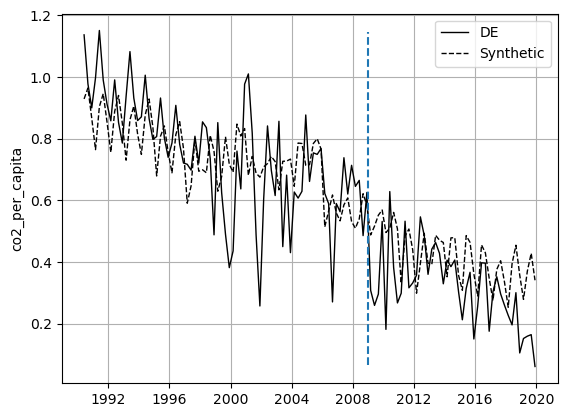

,V,treated,synthetic,sample mean
special.1.tavg,0.348,217.388,218.053,253.166
special.2.eprod_per_capita,0.291,0.000,0.005,0.062
special.3.eflow_per_capita,0.360,-0.030,-0.021,0.029
special.4.gdp_per_capita,0.001,0.006,0.005,0.004


In [60]:
synth.path_plot(time_period=years, treatment_time=pd.to_datetime("2009-01-01"))
synth.summary()

In [61]:
# Do a synthetic control fit to the data using RGGI states
synth = Synth()
#synth.fit(dataprep=dataprep_rggi, optim_method="BFGS")
synth.fit(dataprep=dataprep_rggi)
print(synth.weights(threshold=.001))

NJ    1.0
Name: weights, dtype: float64


/Users/jackjoma/miniconda3/envs/regulators/lib/python3.12/site-packages/pysyncon/dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


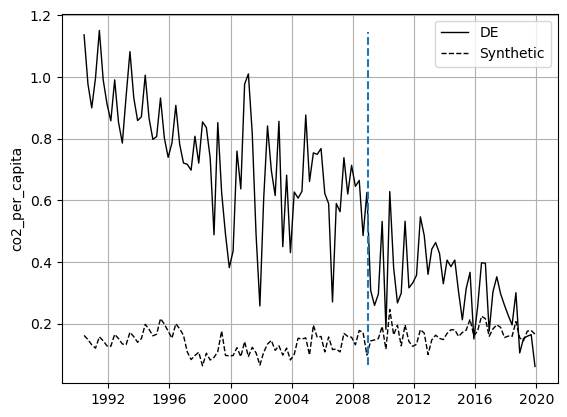

,V,treated,synthetic,sample mean
special.1.tavg,0.253,217.388,227.031,256.670
special.2.eprod_per_capita,0.249,0.000,0.003,0.006
special.3.eflow_per_capita,0.250,-0.030,-0.022,-0.015
special.4.gdp_per_capita,0.249,0.006,0.005,0.005


In [62]:
synth.path_plot(time_period=years, treatment_time=pd.to_datetime("2009-01-01"))
synth.summary()